<a href="https://colab.research.google.com/github/chchang1990/HR_VGF_S2_ML/blob/main/HR_VGFs_SMAP_S2_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Generating High Resolution (10-m) Vegetation Greenness Fraction using Sentinel-2 and SMAP imagery, and Machine Learning**

**Vegetation Greenness Fraction (VGF)** describes the proportion of green vegetation over an area. High resolution VGF data is widely used in many aspects. One of its applications is to **monitor the vegetation growth, and crop yields, which provide valuable insight for agriculture activity** (<a href="https://www.mdpi.com/2072-4292/11/19/2324">Tao et al., 2019</a>).

Conventionally, VGF are commonly calculated with the **"<i>relative vegetation abundance algorithm</i>" by leveraging vegetation index (VI) derived from remotely sensed data**. Simply put, this algorithm calculates VGF as the ratio between the instaneous and the maximal VIs relative to the bare-soil VI. However, **this algorithm requires accurate maximal and bare-soil VIs to give us a skillful VGF estimation, which is quite challenging since they can vary in different geographic regions, and vegetation types** (<a href="https://www.sciencedirect.com/science/article/pii/S0924271619302783">Gao et al., 2020</a>). The level 4 product of the Soil Moisture Active Passive (SMAP) satellite mission, SPL4SMGP, provides the VGF data. However, its 9-km spatial resolution is coarse and may not be fine enough for practical use.

In this Colab script, **I demonstrated a machine learning-based approach to generate high-resolution (10-m) VGF from the Sentinel-2 (S2) imagery by leveraging the Google Earth Engine**. Specifically, I used randomly sampled data from coincident historical S2 Normalized Difference Vegetation Index (NDVI) and SMAP VGF as training data to train a random forest regression model. With this model, any updated high-resolution (10-m) S2 NDVI can be used as input to generate the corresponding high-resolution (10-m) VGF.

# Required Package preparation

**Install required packages**

In [ ]:
!pip install geemap rioxarray

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 67.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 33.8 MB/s eta 0:00:00


**Import relevant packages**

In [ ]:
import ee
import geemap

import numpy as np
import pandas as pd

import xarray as xr
import rioxarray
import rasterio

import datetime

#import seaborn as sbn
import matplotlib.pyplot as plt

import os
import google.colab.drive as drive


**Authenticate and initialize Earth Engine API**

In [ ]:

ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=nSVs1VJrxlVKyBZXFt3tgwfpPEHXKzV-nXXnTaev08s&tc=xHtOhv1evnsVCjA-rkd16sNSahmM6ix6JPLQoETBwHI&cc=KnaH2_7RtJ8OXnK3GHscgph6SVJEKj8fDI-S8bPMy7o

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AfJohXlr7ptrL1MSMkfulLARU4zymifzs-wUtA-DVFYf5q2h1RF5-kd4cdY

Successfully saved authorization token.


**Mount your Google Drive to the Google Colab**

In [ ]:
drive.mount('/content/drive/')
root_gdrive = '/content/drive/MyDrive/'

Mounted at /content/drive/


# Area-Of-Interest (AOI) visualization

**Visualize AOI**

I selected Iowa State as the pilot study site since it has the highest average percentage in the national production of corn and soybean from 2015 - 2019 per USDA (https://ipad.fas.usda.gov/countrysummary/Default.aspx?id=US&crop=Corn)



Let's first visualize how different crops are distributed over Iowa

In [ ]:
aoi = (
    ee.FeatureCollection('TIGER/2018/States')
    .filter(ee.Filter.eq('NAME', 'Iowa'))
).geometry()


In [ ]:
usda_crop = (
    ee.ImageCollection("USDA/NASS/CDL")
    .filterDate('2022-01-01','2022-12-31')
    .first()
    .select('cropland')
) .clip(aoi)

In [ ]:
Map = geemap.Map(center=(42.1,-93.5), zoom=6)
Map.addLayer(usda_crop,{},name='USDA NASS Cropland 2021')
Map.addLayerControl()
Map

Map(center=[42.1, -93.5], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children…

From the USDA Cropland map, we can see there are widespread crop fields, mostly corn and soybean, except the south side of Iowa.

# **Use Google Earth Engine API to retrieve and preprocess SMAP, and S2 images**

## Image Collection retrieval setting

In this project, I selected a target AOI that is in the north Iowa. Let's have a look where the target AOI is located.

In [ ]:
# Iowa state border
#sample_aoi_w, sample_aoi_s, sample_aoi_e, sample_aoi_n = -96.64, 40.41, -90.12, 43.55

sample_aoi_w, sample_aoi_s, sample_aoi_e, sample_aoi_n = -94.73, 42.71, -93.38, 43.54
sample_aoi = ee.Geometry.BBox(sample_aoi_w, sample_aoi_s, sample_aoi_e, sample_aoi_n)

In [ ]:
Map = geemap.Map(center=(42.1,-93.5), zoom=6)
Map.addLayer(usda_crop,{},name='USDA NASS Cropland 2021')
Map.addLayer(sample_aoi,{},name='Sample AOI')
Map.addLayerControl()
Map

Map(center=[42.1, -93.5], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children…

Here are some pre-requisite before proceeding. I set up the time span of S2 and SMAP retrieval, and define a mapping function to clip the image collection to the target AOI

In [ ]:
start_date = '2019-01-01'
end_date = '2023-12-31'

def imgcol_clip(image):
    return image.clip(sample_aoi)


After setting up the target AOI and the time span of data retrieval, let's proceed to get the data from Google Earth Engine and pre-process them.

## S2 image retrieval and processing



Firstly, let's retrieve and pre-process the Sentinel-2 images, which include applying cloud mask and scale the data with the given scale factor. I used **Sentinel-2 MSI: MultiSpectral Instrument, Level-2A** images.
    
    ee.ImageCollection("COPERNICUS/S2_SR")

Then, we can calculate the vegetation indices to be used as input of the machine learning regression model, which is the training feature. There are several vegetation indices can be calculated with the multi-spectral S2 imagery. In this project, I calculated NDVI with Near Infra-Red (NIR) and red bands.

**Function to mask out cloud pixels and apply the scale factor to the data**

In [ ]:
def maskS2clouds(image):
    qa = image.select('QA60');

    # QA has 12 bits from bit-0 to bit-11
    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = 1 << 10; # Push "1" 10 spaces to the left (010000000000)
    cirrusBitMask = 1 << 11; # Push "1" 11 spaces to the left (100000000000)

    # "bitwiseAnd" compare the QA and "cloudBitMask" and "cirrusBitMask"
    # then return True if (1) bit-10 of QA and "cloudBitMask" do not match (no cloud)
    #                     (2) bit-11 of QA and "cirrusBitMask" do not match (no cirrus cloud)
    #
    # Both flags should be set to zero, indicating clear conditions.
    # (a pixel that is neither cloud nor cirrus cloud will be retained)
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0));
    #
    # Mask out the cloud/cirrus-cloud pixels and scale the data by 10000 (the scale factor of the data)
    return image.updateMask(mask).divide(10000).copyProperties(image, ['system:time_start'])

**Functions to calculate NDVI**

In [ ]:
def cal_ndvi(image):
    ndvi = image.expression(
        "(NIR - RED)/(NIR + RED)",
        {
            "NIR": image.select('B8'),
            "RED": image.select('B4')
        }
    ).rename('NDVI').copyProperties(image, ['system:time_start']);
    #image = image.addBands(ndvi)

    return ndvi


**S2 image retrieval, preprocess, and clipping**

In [ ]:
# Use Sentinel-2 data from 2018 to 2022 for training
s2_ImgCol = (
    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterDate(start_date, end_date)
    ##Pre-filter to get less cloudy granules.
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',20))
    .filterBounds(aoi)
).map(maskS2clouds).map(imgcol_clip)

**Calculate S2 NDVI**

In [ ]:
s2_ndvi_ImgCol = s2_ImgCol.map(cal_ndvi)

## SMAP image retrieval and processing

Secondly, let's retrieve the SMAP VGF to be used as desired output of the machine learning regression model, which is the training label. I used **SMAP L4 Global 3-hourly 9-km Surface and Root Zone Soil Moisture**.

    ee.ImageCollection("NASA/SMAP/SPL4SMGP/007")

In [ ]:
smap_band = 'vegetation_greenness_fraction'

smap_ImgCol = (
    ee.ImageCollection("NASA/SMAP/SPL4SMGP/007")
    .select(smap_band)
    .filterDate(start_date,end_date)
    .filterBounds(aoi)
).map(imgcol_clip)

# **Randomly sample data points from coincident S2 NDVI and SMAP VGF to build machine learning regression model**

After retrieving and pre-processing the S2 NDVI and SMAP VGF, let's go ahead to sample the data points from coincident S2 NDVI and SMAP VGF, so that we can use them to train the machine learning regression model. It requires two steps

1. Generate an image colleciton with spatiotemporally coincident S2 NDVI and SMAP VGF

2. Randomly sample the data from each image in the spatiotemporally coincident image collection

**Function to put spatiotemporally coincident S2 NDVI and SMAP VGF as one image collection**

In [ ]:
def space_time_join(primary_data, secondary_data, space_tolerance=100, time_tolerance=1):

    """

    primary_data: data used as reference
    secondary_data: data to be matched with primary_data
    space_tolerance: tolerance to find spatial match (unit: meter)
    time_tolerance: tolerance to find temporal match (unit: day)

    """
    def get_geometry(img):
        return img.geometry()

    def space_time_merge(img):
        BeJoined_ImgCol = ee.ImageCollection.fromImages(img.get(primary_data.__class__.__name__))

        img_geom = img.geometry(100)
        BeJoined_geom = BeJoined_ImgCol.map(get_geometry).union(100).geometry(100)
        overlay = img_geom.intersection(BeJoined_geom, 100)

        BeJoined_ImgCol = BeJoined_ImgCol.mosaic()

        return img.addBands(BeJoined_ImgCol).clip(overlay)


    # Define spatiotemporal filter
    space_time_filter = ee.Filter.And(
        # Time filter
        ee.Filter.maxDifference(
            **{
                "difference": time_tolerance * 1000 * 60 * 60 * 24,  # One day in milliseconds
                "leftField": "system:time_start",
                "rightField": "system:time_start",
            }
        ),
        # Space filter
        ee.Filter.intersects(
            **{"leftField": ".geo", "rightField": ".geo", "maxError": space_tolerance}
        ),
    )

    # apply join on collections and save all results
    saveAllJoin =  ee.Join.saveAll(**{
            "matchesKey": primary_data.__class__.__name__,
            "ordering": "system:time_start",
            "ascending": True
        }
    )

    joined_ImgCol = ee.ImageCollection(saveAllJoin.apply(primary=primary_data, secondary=secondary_data, condition=space_time_filter))
    joined_ImgCol = joined_ImgCol.map(space_time_merge)

    return joined_ImgCol

**Function to sample points of data within the AOI along with the acquisition time**

In [ ]:
# Plot a time series of mean NDVI and CPC in AOI.
def add_date(img):
    img_date = ee.Date(img.date())
    img_date = ee.Number.parse(img_date.format('YYYYMMdd'))
    return img.addBands(ee.Image(img_date).rename('Date').toInt())


def aoi_sample(img):
    sample_data = img.sample(region=sample_aoi, numPixels=30, geometries=True)
    return sample_data

**Function to export the sampled data to Google Drive (It will take awhile, depending on how large your sampled data is)**

In [ ]:
def export_samples(sampled_feature_collection, root_gdrive, out_fname):
    if not os.path.exists(root_gdrive+out_fname+'.csv'):
        task = ee.batch.Export.table.toDrive(**{
            'collection': sampled_feature_collection,
            'description':out_fname,
            'fileFormat': 'csv'
        })
        task.start()

        task = ee.batch.Export.table.toAsset(**{
            'collection': sampled_feature_collection,
            'description':out_fname,
            'assetId': 'users/cchang37ee/'+out_fname
        })
        task.start()
        print('Export the data to Google Drive and Earth Engine Asset. Please read the CSV files after it is done.')
    else:
        print('Training sample already exported.')

Combine spatiotemporally coincident S2 NDVIs and SMAP VGFs

In [ ]:
smap_ndvi_ImgCol = space_time_join(smap_ImgCol, s2_ndvi_ImgCol)


Randomly sample points of data to be used for building machine learning model

In [ ]:
smap_ndvi_sample = smap_ndvi_ImgCol.map(add_date).map(aoi_sample).flatten()

Export the sampled data to the Google Drive as CSV (and Google Earth Engine Asset). This will take a while.

In [ ]:
export_samples(smap_ndvi_sample, root_gdrive, 'smap_ndvi_samples_Iowa_north_30pts')

Training sample already exported.


# **Examine the time-series of S2 NDVI, and SMAP VGF**

Before building a machine learning regression model, it is better to check if there is a correlation between the data, which will give us an idea if a regression model can really be built. Let's look at the time-series and scatter plots of the data.

**Function of making double y-axis plot and scatter plot**

In [ ]:
def make_yyplot(data, ax1_data_name, ax2_data_name, ax1_data_band='NDVI', ax2_data_band='vegetation_greenness_fraction'):

    data_date = pd.to_datetime(pd.unique(data["Date"]), format='%Y%m%d')

    ax1_data = data[["Date",ax1_data_band]] #soil_moisture_am
    ax2_data = data[["Date",ax2_data_band]]

    fig, ax1 = plt.subplots()

    line1 = ax1.plot(data_date, ax1_data.groupby(['Date']).mean())
    ax1.set_ylabel(ax1_data_name, color='C0')
    ax1.tick_params(axis='x', rotation=45)
    ax1.tick_params(axis='y', color='C0', labelcolor='C0')

    ax2 = ax1.twinx()
    line2 = ax2.plot(data_date, ax2_data.groupby(['Date']).mean(),'C1')
    ax2.set_ylabel(ax2_data_name, color='C1')
    ax2.tick_params(axis='y', color='C1', labelcolor='C1')
    ax2.spines['right'].set_color('C1')
    ax2.spines['left'].set_color('C0')
    plt.show()

    plt.scatter(ax1_data[ax1_data_band], ax2_data[ax2_data_band])
    plt.xlabel(ax1_data_name, fontsize=20)
    plt.ylabel(ax2_data_name, fontsize=20)
    plt.show()



First of all, Let's read the sampled data from Google Drive

In [ ]:
try:
    smap_ndvi_samples_df = pd.read_csv(root_gdrive+'smap_ndvi_samples_Iowa_north_30pts.csv')
except:
    print('There is no sample in the CSV (Corn).')


Then, let's make the time-series and scatter plots

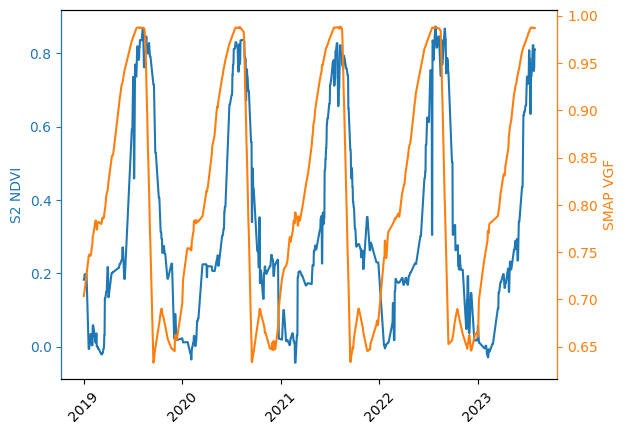

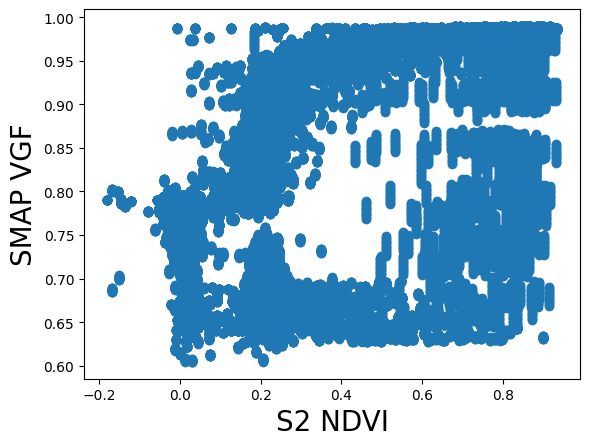

In [ ]:
make_yyplot(smap_ndvi_samples_df, 'S2 NDVI', 'SMAP VGF', 'NDVI', 'vegetation_greenness_fraction')

If we look at the scatter plot, apparently there is a hysteresis pattern in how the data points are distributed. In the time-series plot, we can see that right after the SMAP VGF (orange line) reaches the peak value, it drops down rapidly, much faster than the S2 NDVI (blue line), which could be due to the harvest of the crops in the region.



To verify my inference, I separated the data into two groups based on whether the data acquisition time is within the harvest period or not. The average time frame of harvest and non-harvest period for corn and soybean are shown below, which were obtained from USDA website (https://ipad.fas.usda.gov/countrysummary/Default.aspx?id=US&crop=Soybean).

![](https://drive.google.com/uc?export=view&id=1-6gE5fC5Fa3nC7m-GJT0_5wrGjGq2RLR)


![](https://drive.google.com/uc?export=view&id=1-E3szEBN1Ox77OLrCWiHHGfJGv3LNssq)

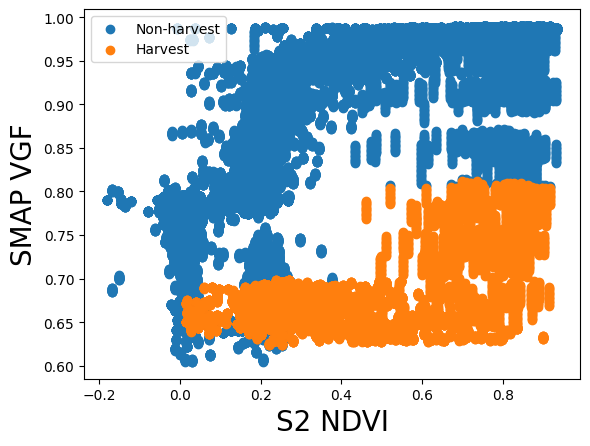

In [ ]:
data_date = pd.to_datetime(pd.to_datetime(smap_ndvi_samples_df["Date"], format='%Y%m%d').values)
ax1_data = smap_ndvi_samples_df["NDVI"]
ax2_data = smap_ndvi_samples_df["vegetation_greenness_fraction"]

index_harvest_period = np.logical_and(data_date.month>=9, data_date.month<=11)
index_nonharvest_period = np.logical_or(data_date.month<9, data_date.month==12)

plt.scatter(ax1_data[index_nonharvest_period], ax2_data[index_nonharvest_period])
plt.scatter(ax1_data[index_harvest_period], ax2_data[index_harvest_period])
plt.xlabel('S2 NDVI', fontsize=20)
plt.ylabel('SMAP VGF', fontsize=20)
plt.legend(['Non-harvest', 'Harvest'])
plt.show()


From the new scatter plot, we can see that the data in each of the separated groups (acquired during the harvest period or not) now have mitigated hysteresis pattern, which verify my inference. It also means that by building two different models for harvest and non-harvest period can help us better estimate the VGFs. The data grouping process may be further refined if a more precise harvesting schedule is available, but let's proceed with what we have at the momment.

# **Build a machine learning model which estimate 10-m resolution VGF maps with S2 NDVI**

Now, let's build machine learning regression model to estimate 10-m resolution VGF with S2 NDVI. I selected data acquired from 2019 to 2021 as training data, and the rest of data were used as test data.

**If you have ready finished sampling the data by running the previous sectors of code, you can start from here directly**

## Build up the machine learning model

Let's first split the data into training and test datasets

In [ ]:
def add_eeDate(feature):
    millis = ee.Date.millis(ee.Date.parse('YYYYMMdd',ee.Number(feature.get('Date')).format('%8d')))
    return feature.set({'system:time_start':millis})

In [ ]:
def train_test_filter(data, feature_name, label_name, training_span, test_span):

    data = data.sort('system:time_start',True)

    training_st_time = training_span[0]
    training_ed_time = training_span[1]

    test_st_time = test_span[0]
    test_ed_time = test_span[1]

    training_data = data.filterDate(training_st_time,training_ed_time).select(['Date','system:time_start',feature_name, label_name]).sort('system:time_start',True)
    test_data = data.filterDate(test_st_time,test_ed_time).select(['Date','system:time_start',feature_name, label_name]).sort('system:time_start',True)

    return training_data, test_data

In [ ]:
sampled_data = ee.FeatureCollection('users/cchang37ee/smap_ndvi_samples_Iowa_north_30pts').map(add_eeDate)

training_span = ['2019-01-01', '2021-12-31']
test_span = ['2022-01-01', '2023-12-31']
training_data, test_data = train_test_filter(sampled_data, 'NDVI', 'vegetation_greenness_fraction', training_span, test_span)

Then, since we will be building separated models for harvest and non-harvest periods, let's separate the data accordingly.

In [ ]:
def data_grouping(data):

    harvest_data = data.filter(ee.Filter.calendarRange(9,11,'month'))
    non_harvest_data = data.filter(ee.Filter.Or(ee.Filter.calendarRange(1,8,'month'),ee.Filter.calendarRange(12,12,'month')))

    return harvest_data, non_harvest_data

In [ ]:
training_harvest_data, training_non_harvest_data = data_grouping(training_data)
test_harvest_data, test_non_harvest_data = data_grouping(test_data)


In [ ]:
# Visualize training sample
Map_training_sample = geemap.Map(center=((sample_aoi_s+sample_aoi_n)/2,(sample_aoi_w+sample_aoi_e)/2), zoom=9)
Map_training_sample.addLayer(sample_aoi,{},name='Sample AOI')
Map_training_sample.addLayer(training_data, {}, "training sample")
Map_training_sample

Map(center=[43.125, -94.055], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(chil…

Now we have the data ready to train a machine learning regression model, which I used the random forest regression model of Google Earth Engine API. Two random forest regression models were built, one for harvest period, the other one for non-harvest period.

In [ ]:
trained_harvest_regressor = (
    ee.Classifier.smileRandomForest(numberOfTrees = 30)
    .setOutputMode('REGRESSION')
    .train(**{
        "features": training_harvest_data,
        "classProperty": 'vegetation_greenness_fraction',
        "inputProperties": ['NDVI']}
    )
)


trained_non_harvest_regressor = (
    ee.Classifier.smileRandomForest(numberOfTrees = 30)
    .setOutputMode('REGRESSION')
    .train(**{
        "features": training_non_harvest_data,
        "classProperty": 'vegetation_greenness_fraction',
        "inputProperties": ['NDVI']}
    )
)

## Visualize the result - High-resolution (10-m) VGF estimated from S2 NDVI with machine learning model

We have finished training the random forest regression models. Now, let's generate high-resolution (10-m) VGF with S2 NDVI and the trained models.

In [ ]:
def estimateVGF_harvest(image):
    temp = image.classify(trained_harvest_regressor)
    temp = temp.where(temp.gt(1), 1)
    vgf = temp.where(temp.lt(0), 0)
    return vgf

def estimateVGF_non_harvest(image):
    temp = image.classify(trained_non_harvest_regressor)
    temp = temp.where(temp.gt(1), 1)
    vgf = temp.where(temp.lt(0), 0)
    return vgf

In case you have finished the data sampling and start from this section directly, I set up the sample AOI and retrieve the USDA cropland layer again here as I want to visualize them along with the S2-estimated high resolution VGF.

In [ ]:
# Iowa state border
#sample_aoi_w, sample_aoi_s, sample_aoi_e, sample_aoi_n = -96.64, 40.41, -90.12, 43.55

sample_aoi_w, sample_aoi_s, sample_aoi_e, sample_aoi_n = -94.73, 42.71, -93.38, 43.54
sample_aoi = ee.Geometry.BBox(sample_aoi_w, sample_aoi_s, sample_aoi_e, sample_aoi_n)

usda_crop = (
    ee.ImageCollection("USDA/NASS/CDL")
    .filterDate('2022-01-01','2022-12-31')
    .first()
    .select('cropland')
) .clip(sample_aoi)

In [ ]:
doi = '2022-06-20'
doi_end = ee.Date(doi).advance(1,'day').format('YYYY-MM-dd')

# Retrieve S2 images, calculate NDVI, and estimate the corresponding VGF
doi_s2_ndvi_ImgCol = (
    ee.ImageCollection("COPERNICUS/S2_SR")
    .filterDate(doi, doi_end)
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',20))
    .filterBounds(aoi)
).map(maskS2clouds).map(imgcol_clip).map(cal_ndvi)

if ee.Date(doi).get('month').getInfo()>=9 and ee.Date(doi).get('month').getInfo()<=11:
    doi_s2_HRVGF_ImgCol = doi_s2_ndvi_ImgCol.map(estimateVGF_harvest)
else:
    doi_s2_HRVGF_ImgCol = doi_s2_ndvi_ImgCol.map(estimateVGF_non_harvest)



# Retrieve SMAP VGF for visual comparison
smap_band = 'vegetation_greenness_fraction'
doi_smap_ImgCol = (
    ee.ImageCollection("NASA/SMAP/SPL4SMGP/007")
    .select(smap_band)
    .filterDate(doi, doi_end)
    .filterBounds(aoi)
).map(imgcol_clip)



# Calculate mean S2-estimated hight resolution VGF, and SMAP VGF acquired on the same date
mean_doi_s2_HRVGF = doi_s2_HRVGF_ImgCol.reduce(ee.Reducer.mean())
mean_doi_smap_VGF = doi_smap_ImgCol.reduce(ee.Reducer.mean())

In [ ]:
## In case you are interested in plotting each individual VGF map acquired on the same date
#ImgCol_size = doi_s2_ndvi_ImgCol.size()
#doi_s2_ndvi_ImgList = doi_s2_ndvi_ImgCol.toList(ImgCol_size)
#doi_s2_HRVGF_ImgList = doi_s2_HRVGF_ImgCol.toList(ImgCol_size)

Now, let's visualize the result. Note that since S2 image has 10m of spatial resolution, which is quite fine. Visualizing on Google Earth Engine map could take a while. If you see nothing on the map at first, probably it's still plotting.

On the other hand, since S2 is an optical sensor whose image could be occluded by cloud, if you don't see anything on the map, it's probably because the S2 images on the selected date-of-interest were too cloudy and were completely masked out. In this case, you can try another date-of-interest and give it a shot.

In [ ]:
vis_VGF = {
   'min':0.4,
   'max':1,
   #'palette':['saddlebrown','sienna','chocolate','peru','burlywood','moccasin','lemonchiffon','honeydew','palegreen','lightgreen','springgreen','lime','limegreen','green','darkgreen']
   'palette':['white','lightgreen','green']
}


sample_aoi_w, sample_aoi_s, sample_aoi_e, sample_aoi_n

Map_output = geemap.Map(center=((sample_aoi_s+sample_aoi_n)/2,(sample_aoi_w+sample_aoi_e)/2), zoom=13)
Map_output.addLayer(usda_crop,{},name='USDA NASS Cropland 2022')
Map_output.addLayer(sample_aoi,{},name='Sample AOI')
Map_output.addLayer(mean_doi_smap_VGF,vis_VGF,name='Mean SMAP VGF:'+doi)
Map_output.addLayer(mean_doi_s2_HRVGF,vis_VGF,name='Mean S2 VGF:'+doi)

## In case you are interested in plotting each individual VGF map acquired on the same date
#for ct_img in np.arange(ImgCol_size.getInfo()):
#    single_img = ee.Image(doi_s2_ndvi_ImgList.get(int(ct_img)))
#    Map_output.addLayer(single_img, vis_ndvi, name='S2 NDVI:'+doi+'-'+str(int(ct_img)).zfill(2))

## In case you are interested in plotting each individual VGF map acquired on the same date
#for ct_img in np.arange(ImgCol_size.getInfo()):
#    single_img = ee.Image(doi_s2_HRVGF_ImgList.get(int(ct_img)))
#    Map_output.addLayer(single_img, vis_VGF, name='S2 VGF:'+doi+'-'+str(int(ct_img)).zfill(2))

Map_output.addLayerControl()
Map_output

Map(center=[43.125, -94.055], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(chil…

From the result above, we can clearly see that we have successfully generated high-resolution (10-m) VGF by using the S2 NDVI and the trained random forest regression model. The 10-m spatial resolution of this S2-estimated VGF is significantly finer than the 9-km resolution of the original SMAP VGF, which is much more informative that can more precisely tell the farmers where their crops are in bad condition and require more cares.

Note that the training data here was sampled randomly over the entire AOI that could encompass different land covers (e.g., different crop types). This could be a reason why the scatter plot between SMAP-VGF and S2-NDVI that we saw earlier has disperse data point distribution, even after we split the data into harvest-time, and non-harvest-time groups. Later, training data may be sampled in either stratified way or separately based on the land covers, and see if the regression model can be improved.